<a href="https://colab.research.google.com/github/urvog/NLP-Sentiment-Analysis/blob/main/NLP_Anger_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd
import numpy as np
import re, string, spacy
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = None
np.random.seed(123)

In [3]:
# Leemos los datos
df = pd.read_csv('sem_eval_train_es.csv', index_col=None)

df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,"@aliciaenp Ajajjaa somos del clan twitteras perdidas pa eventos ""importantes""",False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la cara de help me pls,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. Especialmente por tratarse de él. No hay justificación.,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,"Para llevar a los bebes de un lugar a otro debemos cantarles canciones... Quiero cantarles Gunaa' nibiina (La llorona, en Zapoteco)",False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,"@DalasReview me encanta la terrible hipocresia y doble moral que tiene esta gente, claro, cuando ella te lo quita ILEGALMENTE no importa...",True,False,True,False,False,False,False,False,False,False,False


In [4]:
df.anger = ['a' if x==True else '' for x in df.anger]
df.anticipation = ['b' if x==True else '' for x in df.anticipation]
df.disgust = ['c' if x==True else '' for x in df.disgust]
df.fear = ['d' if x==True else '' for x in df.fear]
df.joy = ['e' if x==True else '' for x in df.joy]
df.love = ['f' if x==True else '' for x in df.love]
df.optimism = ['g' if x==True else '' for x in df.optimism]
df.pessimism = ['h' if x==True else '' for x in df.pessimism]
df.sadness = ['i' if x==True else '' for x in df.sadness]
df.surprise = ['j' if x==True else '' for x in df.surprise]
df.trust = ['k' if x==True else '' for x in df.trust]

In [5]:
df['sentiment'] = df.anger+df.anticipation+df.disgust+df.fear+df.joy+df.love+df.optimism+df.pessimism+df.sadness+df.surprise+df.trust

In [6]:
df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,sentiment
0,2018-Es-01643,"@aliciaenp Ajajjaa somos del clan twitteras perdidas pa eventos ""importantes""",,,,,e,,,,,,,e
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la cara de help me pls,,,,d,,,,h,,,,dh
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. Especialmente por tratarse de él. No hay justificación.,a,,,,,,,,,,,a
3,2018-Es-00208,"Para llevar a los bebes de un lugar a otro debemos cantarles canciones... Quiero cantarles Gunaa' nibiina (La llorona, en Zapoteco)",,,,,e,,,,,,,e
4,2018-Es-01385,"@DalasReview me encanta la terrible hipocresia y doble moral que tiene esta gente, claro, cuando ella te lo quita ILEGALMENTE no importa...",a,,c,,,,,,,,,ac


In [7]:
#Label encoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df.sentiment)

In [8]:
df.head(20)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,sentiment,target
0,2018-Es-01643,"@aliciaenp Ajajjaa somos del clan twitteras perdidas pa eventos ""importantes""",,,,,e,,,,,,,e,137
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la cara de help me pls,,,,d,,,,h,,,,dh,131
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. Especialmente por tratarse de él. No hay justificación.,a,,,,,,,,,,,a,1
3,2018-Es-00208,"Para llevar a los bebes de un lugar a otro debemos cantarles canciones... Quiero cantarles Gunaa' nibiina (La llorona, en Zapoteco)",,,,,e,,,,,,,e,137
4,2018-Es-01385,"@DalasReview me encanta la terrible hipocresia y doble moral que tiene esta gente, claro, cuando ella te lo quita ILEGALMENTE no importa...",a,,c,,,,,,,,,ac,13
5,2018-Es-00089,"En Venezuela, el tráfico aéreo esta tan peligroso como el terrestre? Ya cayó otra avioneta.",,b,,d,,,,h,,,,bdh,70
6,2018-Es-05189,me voy a morir sin saber por qué @. y @.. y @... me dieron block y los espantaré cada noche hasta que se arrepientan,,,,d,,,,,i,,,di,134
7,2018-Es-02108,@tctelevision @calle7tc Terrible esto!,a,,c,,,,,,i,,,aci,25
8,2018-Es-00795,"Para tristeza y felicidad, Ed Sheeran al rescate.🙃",,,,,e,,,,i,,,ei,151
9,2018-Es-02243,"Con razon mi vieja se fue rapido a Santa Fe sin invitarme, no queria que me tatue denuevo",,,,,,,,h,,,,h,172


In [35]:
le = preprocessing.LabelEncoder()
df['target_anger'] = le.fit_transform(df.anger)

In [36]:
df_final = df[['Tweet','target_anger']]
df_final

,Tweet,target_anger
0,ajajjaa ser del clan twittera perdido pa evento importante,0
1,el malo suerte del gato fichame el cara de help yo pls,0
2,a yo tampoco yo agradar mucho ese especialmente por tratar él de él no haber justificación,1
3,para llevar a el beb de uno lugar a otro deber cantar él canción querer cantarl gunaa nibiín el lloronar en zapoteco,0
4,yo encantar el terrible hipocresia y doble moral que tener este gente claro cuando él tú él quitar ilegalmente no importar,1
...,...,...
3556,ahorita querer que mi preocupación más grande ser no poder ir festival de música y ese cosa,0
3557,el mayor criminal del país decir él delincuente a nuestro vicepresidente constitucional irónico quemássepuedeesperardeesasbasura,1
3558,mi prima de 4 año él haber enfadar yo porque él haber explicar de el azul no ser solo de chico ni el rosa de chica que él enseñar,1
3559,jajajar ya seee,0


# Limpiamos los datos

In [37]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

## Preparamos el conjunto de datos
Convertimos el texto en *tokens* y asignamos una ID numérica a cada token.  
Convertimos a secuencias de longitud fija.  
La longitud de la secuencia viene dada por la longitud en tokens del tweet más largo. Sólo se conservan los tokens de las palabras en el vocabulario.

In [46]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.Tweet=df.Tweet.apply(clean_text, lemas=True)
df = df[df['Tweet']!='']

#Enviamos a Y los codigos asignados por label encodr, hay que convertir a numérico para Keras
Y=df.target_anger

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.Tweet,Y, test_size = 0.3, random_state = 42)

In [47]:
#Tokenizamos los textos
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(tweets_train.values)
X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Número de tokens distintos: {len(word_index)}')
MAX_SEQUENCE_LENGTH = X_train.shape[1]
max_features = len(word_index)+1
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Número de tokens distintos: 5632


In [48]:
tokenizer.document_count

2492

In [49]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2492, 33) (2492,)
(1069, 33) (1069,)


In [50]:
print("Clases:", df_final.target_anger.nunique())

Clases: 2


#Modelo Convolucional

## Preparacion del Modelo

In [51]:
#Creamos el modelo CNN en Keras
#pero quitamos la capa oculta intermedia para simplificar el modelo y dejarlo como en el artículo

#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

# conectamos a una capa de salida de una unidad con activación relu
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 33, 50)            281650    
                                                                 
 dropout_9 (Dropout)         (None, 33, 50)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 31, 64)            9664      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
 activation_9 (Activation)   (None, 1)                 0         
                                                      

## Entrenamos

In [52]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
156/156 - 1s - loss: 0.6365 - accuracy: 0.6573 - val_loss: 0.6197 - val_accuracy: 0.6745 - 1s/epoch - 9ms/step
Epoch 2/20
156/156 - 1s - loss: 0.5506 - accuracy: 0.7147 - val_loss: 0.5046 - val_accuracy: 0.7699 - 671ms/epoch - 4ms/step
Epoch 3/20
156/156 - 1s - loss: 0.3461 - accuracy: 0.8511 - val_loss: 0.4968 - val_accuracy: 0.7727 - 675ms/epoch - 4ms/step
Epoch 4/20
156/156 - 1s - loss: 0.1880 - accuracy: 0.9354 - val_loss: 0.5600 - val_accuracy: 0.7699 - 656ms/epoch - 4ms/step
Epoch 5/20
156/156 - 1s - loss: 0.0931 - accuracy: 0.9767 - val_loss: 0.6586 - val_accuracy: 0.7708 - 677ms/epoch - 4ms/step
Epoch 6/20
156/156 - 1s - loss: 0.0544 - accuracy: 0.9904 - val_loss: 0.7477 - val_accuracy: 0.7587 - 673ms/epoch - 4ms/step
Epoch 7/20
156/156 - 1s - loss: 0.0338 - accuracy: 0.9940 - val_loss: 0.8088 - val_accuracy: 0.7512 - 649ms/epoch - 4ms/step
Epoch 8/20
156/156 - 1s - loss: 0.0260 - accuracy: 0.9948 - val_loss: 0.8712 - val_accuracy: 0.7493 - 670ms/epoch - 4ms/step
Epo

## Visualizamos el aprendizaje

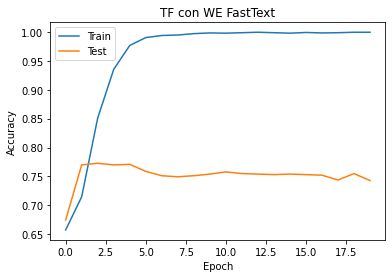

In [69]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con WE FastText')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Inferencias al modelo

In [80]:
twt = 'estoy muy alegre con este viaje'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
twt

[[12, 29, 407, 17, 19, 631]]

In [81]:
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='post', value=0)
twt

array([[ 12,  29, 407,  17,  19, 631,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [82]:
sentiment = model.predict(twt,batch_size=1,verbose = 2)
if(np.round(sentiment) == 0):
    print("Desconocido")
elif (np.round(sentiment) == 1):
    print("Enojo")

1/1 - 0s - 13ms/epoch - 13ms/step
Desconocido


In [83]:
sentiment = model.predict(twt,batch_size=1)
sentiment

array([[3.4278487e-06]], dtype=float32)

# Transfer Learning con Word Embeddings de Glove y RNN

In [93]:
#Definimos características de la capa RNN

RNN_DIM = 50 #Nº de neuronas en la capa RNN
RNN_layer = LSTM #usar GRU o LSTM

In [85]:
#Estimamos el tamaño de vocabulario (parabras con un min_df de 2 en TRAIN)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=2)
cv.fit(tweets_train)
max_features = len(cv.get_feature_names())
print('Tamaño vocabulario: {}'.format(max_features))

Tamaño vocabulario: 1763


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [86]:
MAX_NB_WORDS = max_features+2 #hay que considerar 1 término más para el OOV y otro para el 0
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ', oov_token='OOV')
tokenizer.fit_on_texts(tweets_train.values)

X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
MAX_SEQUENCE_LENGTH = X_train.shape[1]

X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
# Note that you could "pre" padding (at the beginning) or
# "post" padding (at the end).
# We recommend using "post" padding when working with RNN layers
# (in order to be able to use the 
# CuDNN implementation of the layers).

Found 5633 unique tokens.


In [87]:
#Rellenamos los vectores con el valor en spaCy para la MAX_NB_WORDS palabras más frecuentes
nlp=spacy.load('es_core_news_md')


EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
vectores = 0
for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        embedding_vector = nlp.vocab[word].vector
        if not np.array_equal(embedding_vector, np.zeros(EMBEDDING_DIM)):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            vectores += 1
        
print("Cargados {} vectores en la matriz".format(vectores))

Cargados 1671 vectores en la matriz


In [88]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2492, 33) (2492,)
(1069, 33) (1069,)


In [94]:

#Creamos el modelo RNN en Keras usando los embeddings cargados como pesos
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            mask_zero=True)

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(RNN_DIM, dropout=0.2, recurrent_dropout=0.2)) #no usamos recurrent_dropout=0.2 por problemas con el M1
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 33, 300)           529500    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 33, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 599,751
Trainable params: 70,251
Non-trainable params: 529,500
_________________________________________________________________
None


## Training Model

In [96]:
batch_size=16
history=model.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=10, validation_data=(X_test, Y_test))

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


## Visualizamos el entrenamiento

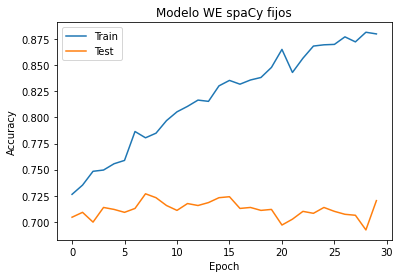

In [98]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE spaCy fijos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluamos

In [100]:
score,acc = model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.75
acc: 0.72


# Transfer Learning con Embbedings Propios

In [101]:
model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH, mask_zero=True))
model3.add(SpatialDropout1D(0.4))
model3.add(RNN_layer(RNN_DIM, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 33, 50)            88250     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 33, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 108,501
Trainable params: 108,501
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
history=model3.fit(X_train, Y_train, epochs=30, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/30
156/156 - 30s - loss: 0.6422 - accuracy: 0.6754 - val_loss: 0.6166 - val_accuracy: 0.6745 - 30s/epoch - 189ms/step
Epoch 2/30
156/156 - 29s - loss: 0.5205 - accuracy: 0.7396 - val_loss: 0.5292 - val_accuracy: 0.7399 - 29s/epoch - 189ms/step
Epoch 3/30
156/156 - 25s - loss: 0.3744 - accuracy: 0.8379 - val_loss: 0.5216 - val_accuracy: 0.7409 - 25s/epoch - 158ms/step
Epoch 4/30
156/156 - 25s - loss: 0.2984 - accuracy: 0.8784 - val_loss: 0.5955 - val_accuracy: 0.7549 - 25s/epoch - 157ms/step
Epoch 5/30
156/156 - 25s - loss: 0.2557 - accuracy: 0.8965 - val_loss: 0.5780 - val_accuracy: 0.7661 - 25s/epoch - 159ms/step
Epoch 6/30
156/156 - 25s - loss: 0.2151 - accuracy: 0.9193 - val_loss: 0.5993 - val_accuracy: 0.7418 - 25s/epoch - 162ms/step
Epoch 7/30
156/156 - 27s - loss: 0.1849 - accuracy: 0.9298 - val_loss: 0.6486 - val_accuracy: 0.7502 - 27s/epoch - 173ms/step
Epoch 8/30
156/156 - 25s - loss: 0.1662 - accuracy: 0.9362 - val_loss: 0.6658 - val_accuracy: 0.7306 - 25s/epoch - 163

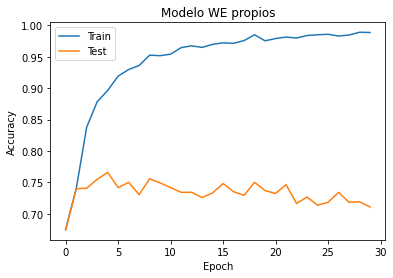

In [106]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE propios')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [107]:
score,acc = model3.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.44
acc: 0.71
